# Predicting Electricity Consumption

Data source: 
- Training: `data-sources/clouds/clouds_train/`
- Testing : `data-sources/clouds/clouds_test/`

Predicting: 
- cirriform clouds      : 0, 
- clear sky             : 1,
- cumulonimbus clouds   : 2,
- cumulus clouds        : 3,
- high cumuliform clouds: 4,
- stratiform clouds     : 5,
- stratocumulus clouds  : 6

## 1. Prepare environment

In [1]:
# Importing libraries
import expectexception
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment

from typing import List, Tuple

from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import MeanSquaredError

In [2]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

# returns you the name of the device
GPU_DEVICE = torch.cuda.current_device()
print('Device:', torch.cuda.get_device_name(GPU_DEVICE))  

# Reviewing allocated memmory, it is 0 if there is nothing allocated
print(f"""
CUDA memory device: {torch.cuda.memory_allocated(GPU_DEVICE)}
CUDA cache  device: {torch.cuda.memory_reserved(GPU_DEVICE)}
""")

2.4.1+cu124
Cuda is available? True
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU

CUDA memory device: 0
CUDA cache  device: 0



In [3]:
# Global variables
SEED = 42

GPU_DEVICE = torch.cuda.current_device()

DATASET_ELECTRICITY_CONSUMPTION_TRAIN = 'data-sources/electricity_train.csv'
DATASET_ELECTRICITY_CONSUMPTION_TEST = 'data-sources/electricity_test.csv'

MODEL_LSTM_ELECTRICITY_CONSUMPTION = "artifacts/lstm-electricity-consumption.pth"

In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)
torch.set_default_dtype(torch.float32)

# Reproducibility
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

### Utilities

In [5]:
class SequenceDataSet(TensorDataset):
    """
    PyTorch TensorDataset Dataset extended to create sequence dataset given CSV file
    Assumptions:
    - Only CSV files can be imported.
    - Number of features are defined by seq_length
    - The last column of the loaded dataset is the only value considered for the 
      sequence and target.
    - Uses GPU device.
    """
    # tensors: Tuple[Tensor, ...]
    
    def __init__(self, csv_path:str, 
                 seq_length:int,
                 since_date: str = None,
                 until_date: str = None,
                 gpu_device:int = GPU_DEVICE) -> torch.utils.data.dataset.TensorDataset:
        data = pd.read_csv(csv_path, parse_dates=['timestamp'])
        if since_date:
            data = data[data.timestamp>=since_date]
        if until_date:
            data = data[data.timestamp<since_date]
        xs, ys = self.create_sequences_(data, seq_length, gpu_device)
        
        super().__init__(xs, ys)
        self.tensors = [xs, ys]

    def create_sequences_(self, df:pd.DataFrame, 
                          seq_length:int,
                          gpu_device:int) -> Tuple[torch.Tensor, torch.Tensor]:
        data = df.iloc[:, -1].values                # Extract column as NumPy array
        # Sliding windows, size `seq_length`
        xs = np.lib.stride_tricks.sliding_window_view(data[:-1], seq_length)  
        ys = data[seq_length:]                      # Target (next val after sequence)
        return (torch.tensor(xs).float().cuda(gpu_device), 
                torch.tensor(ys).float().cuda(gpu_device))

In [6]:
class GruSeqToVectorModel(nn.Module):
    """GRU Sequence to vector model to predict electricity consumption."""
    def __init__(self, 
                 input_size=1,        # Only 1-feature: electricity consumption
                 hidden_size=32,      # Choosen arbitrary
                 num_layers=2,        # Choosen arbitrary
                 output_size=1,       # Timeseries problem
                 dropout=0.0,         # To reduce overfitting
                 gpu_device:int = GPU_DEVICE):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gpu_device = gpu_device
        
        torch.manual_seed(SEED)       # Reproducibility
        self.gru = nn.GRU(            # Define the LSTM model
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,         # Batch Size will be it first dimension
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, output_size)  # Linear layer
        self.float()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)\
                  .float().cuda(self.gpu_device)
        out, _ = self.gru(x, h0)      # Pass input x, h0 and h1 by RNN
        out = self.fc(out[:, -1, :])  # Process last output (middel dim)
        return out

## 2. Review datasets

In [7]:
print('TRAIN DATASET:')
df_train = pd.read_csv(DATASET_ELECTRICITY_CONSUMPTION_TRAIN, parse_dates=['timestamp'])
print(df_train.describe(include='all'))
print(df_train.shape)
df_train

TRAIN DATASET:
                           timestamp    consumption
count                         105216  105216.000000
mean   2012-07-02 00:07:29.999999744      -0.007478
min              2011-01-01 00:15:00      -1.414483
25%              2011-10-02 00:11:15      -0.957931
50%              2012-07-02 00:07:30      -0.349363
75%              2013-04-02 00:03:45       0.797593
max              2014-01-01 00:00:00       3.028924
std                              NaN       1.056834
(105216, 2)


,timestamp,consumption
0,2011-01-01 00:15:00,-0.704319
1,2011-01-01 00:30:00,-0.704319
2,2011-01-01 00:45:00,-0.678983
3,2011-01-01 01:00:00,-0.653647
4,2011-01-01 01:15:00,-0.704319
...,...,...
105211,2013-12-31 23:00:00,-0.907259
105212,2013-12-31 23:15:00,-0.932595
105213,2013-12-31 23:30:00,-0.932595
105214,2013-12-31 23:45:00,-0.932595


In [8]:
print('TEST DATASET:')
df_test = pd.read_csv(DATASET_ELECTRICITY_CONSUMPTION_TEST, parse_dates=['timestamp'])
print(df_test.describe(include='all'))
print(df_test.shape)
df_test

TEST DATASET:
                 timestamp   consumption
count                35040  35040.000000
mean   2014-07-02 11:52:30      0.022430
min    2014-01-01 00:00:00     -1.414483
25%    2014-04-02 05:56:15     -0.729908
50%    2014-07-02 11:52:30     -0.095751
75%    2014-10-01 17:48:45      0.695742
max    2014-12-31 23:45:00      2.645845
std                    NaN      0.805208
(35040, 2)


,timestamp,consumption
0,2014-01-01 00:00:00,-0.932595
1,2014-01-01 00:15:00,-0.957931
2,2014-01-01 00:30:00,-0.932595
3,2014-01-01 00:45:00,-0.907259
4,2014-01-01 01:00:00,-0.881923
...,...,...
35035,2014-12-31 22:45:00,-0.070415
35036,2014-12-31 23:00:00,-0.045079
35037,2014-12-31 23:15:00,-0.045079
35038,2014-12-31 23:30:00,-0.045079


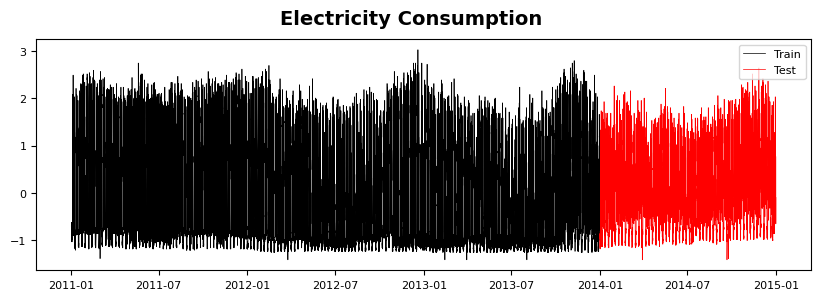

In [9]:
fig = plt.figure(figsize=(10, 3))
plt.plot(df_train.timestamp, df_train.consumption, c='black', lw=.5, label='Train')
plt.plot(df_test.timestamp, df_test.consumption, c='red', lw=.5, label='Test')
plt.legend()
fig.suptitle('Electricity Consumption')
plt.show()

## 3. Get dataloader

In [10]:
# Get the dataset
start = time.time()

seq_length = 24*4
dataset_train = SequenceDataSet(csv_path=DATASET_ELECTRICITY_CONSUMPTION_TRAIN,
                                seq_length=seq_length)
dataset_test = SequenceDataSet(csv_path=DATASET_ELECTRICITY_CONSUMPTION_TEST,
                               seq_length=seq_length)
print(f'\nExecution time: {time.time()-start} s.')

start = time.time()

print(f"""
Train dataset size: {len(dataset_train)}
Test dataset size: {len(dataset_test)}
""")
print(f'Execution time: {time.time()-start} s.')

# Create the data loader
torch.manual_seed(SEED)  # Reproducibility
dataloader_train = DataLoader(dataset_train, shuffle=False, batch_size=16)
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=32)


Execution time: 0.31459736824035645 s.

Train dataset size: 105120
Test dataset size: 34944

Execution time: 0.0 s.


## 4. Build the model

In [11]:
# Build the model
model = GruSeqToVectorModel(dropout=0.2).cuda(GPU_DEVICE)
print(f"Are we using GPU? {next(model.parameters()).is_cuda}\n")
print(model)

# Set the criterion and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Are we using GPU? True

GruSeqToVectorModel(
  (gru): GRU(1, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## 5. Train the model

In [12]:
# Train the model
losses = []
epochs = 100
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    
    for X, y in dataloader_train:        # Get feature and target from the data loader
        optimizer.zero_grad()            # zero the parameter gradients
        X = X.view(16, 96, 1)            # prev=(16, 96), post=(16, 96, 1)
        y_pred = model(X).squeeze()      # Run a forward pass
        loss = criterion(y_pred, y)      # Compute loss
        loss.backward()                  # Backward pass
        optimizer.step()                 # Optimization
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)            # Record the loss per epoch
    if (epoch + 1) % 10 == 0:            # Print the loss every 10 epochs
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 10, Loss: 0.042102
Epoch 20, Loss: 0.039382
Epoch 30, Loss: 0.038709
Epoch 40, Loss: 0.036909
Epoch 50, Loss: 0.036887
Epoch 60, Loss: 0.037292
Epoch 70, Loss: 0.037017
Epoch 80, Loss: 0.036641
Epoch 90, Loss: 0.040569
Epoch 100, Loss: 0.038765


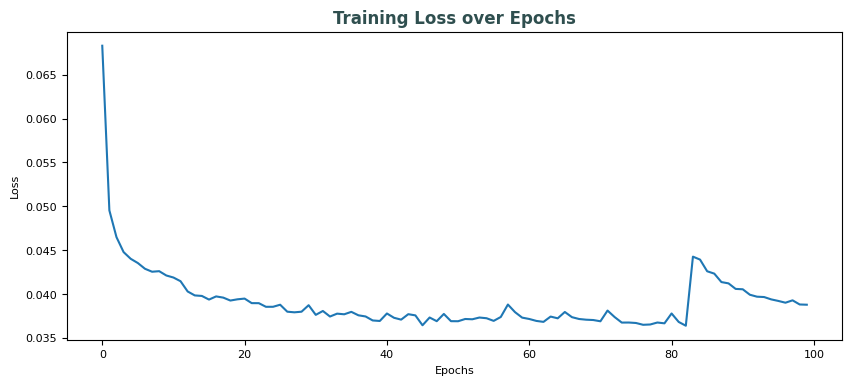

In [13]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Save the model

In [14]:
# Saving the model
torch.save(model, MODEL_LSTM_ELECTRICITY_CONSUMPTION)

## 7. Load the model

In [15]:
model = torch.load(MODEL_LSTM_ELECTRICITY_CONSUMPTION,
                   weights_only=False)

## 8. Evaluate model

In [16]:
mse = MeanSquaredError().to(GPU_DEVICE)

model.eval()
with torch.no_grad():
    for X, y in dataloader_test:
        X = X.view(32, 96, 1)
        y_pred = model(X).squeeze()
        mse(y_pred, y)
lstm_mse = mse.compute()
print(f"Test MSE: {lstm_mse}")

Test MSE: 0.08578793704509735


In [17]:
pd.DataFrame({
    'y_true': y.cpu().numpy(),
    'y_pred': y_pred.cpu().numpy(),
    'Dif': y.cpu().numpy() - y_pred.cpu().numpy()
})

,y_true,y_pred,Dif
0,0.416034,0.491820,-0.075786
1,0.568810,0.475118,0.093692
2,0.619481,0.684934,-0.065452
3,0.695742,0.702554,-0.006811
4,0.721332,0.774211,-0.052880
5,0.772003,0.754383,0.017621
6,0.543220,0.807932,-0.264712
7,0.492295,0.273998,0.218297
8,0.543220,0.405439,0.137782
9,0.492295,0.622097,-0.129801


## 9. Close environment

In [18]:
# Reviewing allocated memmory, it is 0 if there is nothing allocated
print(f"""
CUDA memory device: {torch.cuda.memory_allocated(GPU_DEVICE)}
CUDA cache  device: {torch.cuda.memory_reserved(GPU_DEVICE)}
""")

# Free allocated memory
del model, X, y
torch.cuda.empty_cache() 


CUDA memory device: 72339456
CUDA cache  device: 100663296



----------------------------------